# GAN Generative Adversarial Network
### Using Tensorflow/Keras

1. Conditional Generative Adversarial Networks
2. Fashion-MNIST Clothing Photograph Dataset
3. Unconditional GAN for Fashion-MNIST
4. Conditional GAN for Fashion-MNIST
5. Conditional Clothing Generation

## Imports

In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from matplotlib import pyplot
import tensorflow as tf
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout

## Model

### Discriminator

In [2]:
def discriminator(in_shape=(28,28,1)):
    
    model = Sequential()
    
    # convolutional layer
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    
    # convolutional layer
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # discriminate
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile 
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### Generator

In [3]:
def generator(latent_dim):
    
    n_nodes = 128 * 7 * 7
    
    model = Sequential()
    
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # generate
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

### GAN

In [4]:
def GAN(generator, discriminator):
    
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    
    # build model
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    # compile 
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

## Testing

### Load data

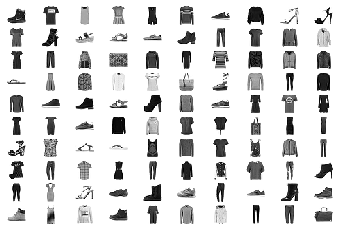

In [5]:
(trainX, trainy), (testX, testy) = load_data()

for i in range(100):
    pyplot.subplot(10, 10, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(trainX[i], cmap='gray_r')


In [6]:
# expand to 3d, e.g. add channels
X = expand_dims(trainX, axis=-1)
    
# convert from ints to floats
X = X.astype('float32')
    
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5

In [7]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    
    # select images
    X = dataset[ix]
    
    # generate class labels
    y = ones((n_samples, 1))
    return X, y

In [8]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [9]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # predict outputs
    X = generator.predict(x_input)
    
    # create class labels
    y = zeros((n_samples, 1))
    return X, y

In [10]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    
    # save the generator model
    g_model.save('generator.h5')

In [11]:
gpu_id = 3398406422290625902
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=gpu_id)):
    latent_dim = 100
    disc = discriminator()
    gen = generator(latent_dim)
    gan = GAN(gen, disc)

    dataset = X
    train(gen, disc, gan, dataset, latent_dim)

>1, 1/468, d1=0.655, d2=0.695 g=0.691
>1, 2/468, d1=0.591, d2=0.701 g=0.686
>1, 3/468, d1=0.531, d2=0.710 g=0.677
>1, 4/468, d1=0.480, d2=0.726 g=0.665
>1, 5/468, d1=0.428, d2=0.743 g=0.651
>1, 6/468, d1=0.381, d2=0.766 g=0.636
>1, 7/468, d1=0.345, d2=0.793 g=0.618
>1, 8/468, d1=0.323, d2=0.816 g=0.608
>1, 9/468, d1=0.303, d2=0.834 g=0.615
>1, 10/468, d1=0.326, d2=0.816 g=0.638
>1, 11/468, d1=0.290, d2=0.766 g=0.693
>1, 12/468, d1=0.321, d2=0.707 g=0.774
>1, 13/468, d1=0.297, d2=0.613 g=0.866
>1, 14/468, d1=0.311, d2=0.532 g=0.994
>1, 15/468, d1=0.316, d2=0.461 g=1.120
>1, 16/468, d1=0.319, d2=0.408 g=1.191
>1, 17/468, d1=0.299, d2=0.418 g=1.150
>1, 18/468, d1=0.308, d2=0.486 g=1.014
>1, 19/468, d1=0.265, d2=0.568 g=0.866
>1, 20/468, d1=0.323, d2=0.651 g=0.764
>1, 21/468, d1=0.261, d2=0.742 g=0.683
>1, 22/468, d1=0.374, d2=0.882 g=0.584
>1, 23/468, d1=0.240, d2=1.041 g=0.499
>1, 24/468, d1=0.183, d2=1.151 g=0.459
>1, 25/468, d1=0.168, d2=1.162 g=0.461
>1, 26/468, d1=0.172, d2=1.098 g=0

## Generate new samples

In [14]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

# load model
model = load_model('generator.h5')
latent_points, labels = generate_latent_points(100, 100)
labels = asarray([x for _ in range(10) for x in range(10)])
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
save_plot(X, 10)

ValueError: in user code:

    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1082 predict_function  *
        outputs = self.distribute_strategy.run(
    c:\program files\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\program files\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\program files\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1057 predict_step  **
        return self(x, training=False)
    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:884 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    c:\program files\python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:155 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer sequential_1 expects 1 inputs, but it received 2 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 100) dtype=float32>, <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int32>]


## Credits and links

https://machinelearningmastery.com/how-to-develop-a-conditional-generative-adversarial-network-from-scratch/